In [1]:
import sentencepiece
from transformers import pipeline

In [2]:
import random
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

df_reviews = pd.read_csv('./data/reviews.csv', delimiter=',', decimal='.', encoding='UTF-8')
df_reviews1 = df_reviews.dropna(how='any')

df_reviews1.head()

,id_review,review,title,score,likes,id_nick,service,date,platform
0,R1245,Muy buena presentación y servicio sin embargo ...,Muy buena presentación y servicio,3.0,0,uisahelenad2018,71036.0,1 years ago,tripadvisor
1,R1246,Desde la presentación de los platos a la calid...,Una experiencia,5.0,0,turrutia,71036.0,1 years ago,tripadvisor
2,R1247,El mejor lugar para reencontrame con mis amigo...,Felicitaciones a Statera!,5.0,0,orthStar25333985745,71036.0,1 years ago,tripadvisor
3,R1248,Excelente experiencia Comida maravillosa con e...,Aniversario de boda,5.0,0,atima J,71036.0,1 years ago,tripadvisor
4,R1249,Mi pasión es viajar y disfrutar de las grandez...,No te lo querrás perder!,5.0,0,nbocadoalmundo,71036.0,1 years ago,tripadvisor


In [3]:
df_reviews1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 755066 entries, 0 to 1258434
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id_review  755066 non-null  object 
 1   review     755066 non-null  object 
 2   title      755066 non-null  object 
 3   score      755066 non-null  float64
 4   likes      755066 non-null  int64  
 5   id_nick    755066 non-null  object 
 6   service    755066 non-null  float64
 7   date       755066 non-null  object 
 8   platform   755066 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 57.6+ MB


In [4]:
classifier = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

In [6]:
import spacy
from collections import Counter
import pandas as pd

nlp = spacy.load('es_core_news_sm')
word_freq_total = Counter()

for index, row in df_reviews1.iterrows():
    text = row['review']
    doc = nlp(text)
    word_freq = Counter(token.text.lower() for token in doc if not token.is_stop and token.is_alpha)
    word_freq_total.update(word_freq)

most_common_words = word_freq_total.most_common(30)  # Cambia 10 por el número de palabras más comunes que desees obtener

data = {}

for word, freq in most_common_words:
    print(f'{word}: {freq}')
    data[word] = freq

df_palabras = pd.DataFrame(data.items(), columns=['palabra', 'cantidad'])
df_palabras.head()

comida: 157564
atención: 138327
lugar: 109523
excelente: 89912
rico: 64402
platos: 47687
servicio: 44378
agradable: 41718
pollo: 41137
ambiente: 40154
sabor: 36113
precios: 29786
precio: 27998
local: 27039
calidad: 25467
restaurante: 25179
comer: 24728
recomiendo: 24668
atencion: 24137
variedad: 21722
delicioso: 21075
rica: 20481
lima: 18676
recomendable: 17448
carta: 17188
ceviche: 15999
acogedor: 15880
familia: 14688
personal: 14589
recomendado: 14272


,palabra,cantidad
0,comida,157564
1,atención,138327
2,lugar,109523
3,excelente,89912
4,rico,64402


<Figure size 1400x1400 with 0 Axes>

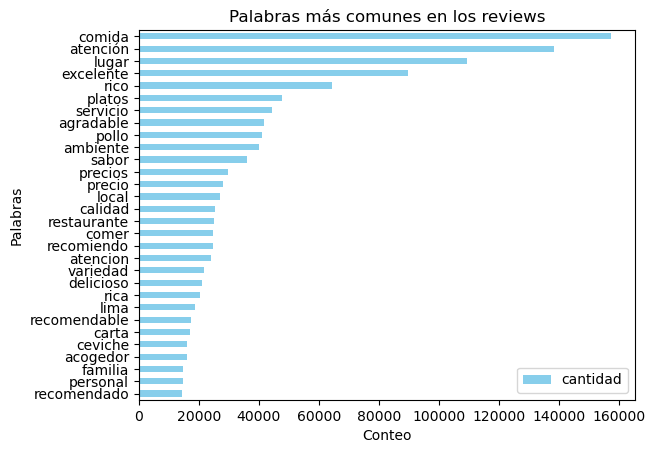

In [8]:
import matplotlib.pyplot as plt

df_palabras = df_palabras.sort_values(by='cantidad')

plt.figure(figsize=(14, 14))
df_palabras.plot(kind='barh', x='palabra', y='cantidad', color='skyblue')
plt.title('Palabras más comunes en los reviews')
plt.xlabel('Conteo')
plt.ylabel('Palabras')
plt.show()

In [2]:
import spacy
import pandas as pd
from collections import Counter
import math

# Cargar el modelo de spaCy (asegúrate de haber descargado el modelo adecuado)
nlp = spacy.load("es_core_news_sm")  # Cambia a "en_core_web_sm" para inglés

def preprocess_text(text):
    doc = nlp(text)
    # Filtrar tokens: solo palabras, sin puntuación ni stopwords
    return [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]

def calculate_tfidf(df):
    # Preprocesar todas las reseñas
    processed_reviews = df['review'].apply(preprocess_text)
    
    # Calcular TF (Term Frequency)
    tf = Counter()
    for review in processed_reviews:
        tf.update(review)
    
    # Calcular IDF (Inverse Document Frequency)
    num_docs = len(df)
    idf = {}
    for word in tf:
        doc_count = sum(1 for review in processed_reviews if word in review)
        idf[word] = math.log(num_docs / (1 + doc_count))
    
    # Calcular TF-IDF
    tfidf = {word: freq * idf[word] for word, freq in tf.items()}
    return tfidf

def get_representative_words(df):
    # Calcular TF-IDF
    tfidf = calculate_tfidf(df)
    
    # Ordenar palabras por su puntuación TF-IDF
    sorted_words = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    
    # Mostrar las 20 palabras más representativas
    print("Las 20 palabras más representativas:")
    for word, score in sorted_words[:20]:
        print(f"{word}: {score:.4f}")
    
    # Análisis adicional: palabras más frecuentes por puntaje
    df['processed_review'] = df['review'].apply(preprocess_text)
    
    score_words = {}
    for score in df['score'].unique():
        words = [word for review in df[df['score'] == score]['processed_review'] for word in review]
        score_words[score] = Counter(words).most_common(10)
    
    print("\nPalabras más frecuentes por puntaje:")
    for score, words in score_words.items():
        print(f"\nPuntaje {score}:")
        for word, count in words:
            print(f"  {word}: {count}")

In [3]:
get_representative_words(df_reviews1)

Las 20 palabras más representativas:
comida: 261083.4192
atención: 238203.2074
lugar: 224666.2228
excelente: 202072.7349
rico: 200945.6529
plato: 159020.9280
precio: 148946.3873
servicio: 130751.2297
pollo: 130558.7563
agradable: 126770.1833
sabor: 123399.9673
ambiente: 121407.0806
restaurante: 102556.0827
local: 100117.6376
comer: 97440.4443
delicioso: 92561.6321
pedir: 88219.0456
calidad: 87663.1681
atencion: 83553.2682
recomeir: 83201.0338


D:\Usuarios\jchata\AppData\Local\Temp\ipykernel_6848\2864429476.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_review'] = df['review'].apply(preprocess_text)



Palabras más frecuentes por puntaje:

Puntaje 3.0:
  comida: 19383
  atención: 15428
  lugar: 12330
  rico: 9431
  precio: 8961
  plato: 8013
  sabor: 6439
  agradable: 6418
  pollo: 6069
  local: 5655

Puntaje 5.0:
  comida: 81159
  excelente: 75381
  atención: 70311
  lugar: 60081
  rico: 52604
  plato: 25636
  servicio: 22598
  precio: 22412
  ambiente: 21882
  delicioso: 20628

Puntaje 4.0:
  comida: 48436
  atención: 38844
  lugar: 34990
  rico: 30837
  precio: 20217
  plato: 18910
  excelente: 17468
  agradable: 17401
  ambiente: 14147
  pollo: 13553

Puntaje 2.0:
  comida: 6125
  atención: 5479
  plato: 2995
  sabor: 2945
  lugar: 2887
  pedir: 2722
  precio: 2575
  malo: 2397
  pollo: 2379
  servicio: 2224

Puntaje 1.0:
  atención: 8373
  comida: 7005
  malo: 5452
  pésimo: 4795
  pedir: 4269
  servicio: 3794
  pollo: 3643
  lugar: 3632
  plato: 3415
  sabor: 3078


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

df = df_reviews_sample.copy()

# Cargar el modelo BERT y el tokenizador
model_name = "dccuchile/bert-base-spanish-wwm-uncased"  # Modelo BERT en español
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_bert_embeddings(text, model, tokenizer):
    # Tokenizar y obtener embeddings
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Usar el embedding del token [CLS] como representación de la frase
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings[0]

def calculate_word_importance(df):
    # Obtener embeddings para cada reseña
    df['embeddings'] = df['review'].apply(lambda x: get_bert_embeddings(x, model, tokenizer))
    
    # Calcular el embedding promedio de todas las reseñas
    average_embedding = np.mean(df['embeddings'].tolist(), axis=0)
    
    # Calcular la importancia de cada palabra
    word_importance = defaultdict(list)
    for _, row in df.iterrows():
        tokens = tokenizer.tokenize(row['review'])
        for token in set(tokens):  # Usar set para considerar cada palabra una vez por reseña
            # Obtener el embedding de la palabra en contexto
            inputs = tokenizer(token, return_tensors="pt")
            with torch.no_grad():
                outputs = model(**inputs)
            token_embedding = outputs.last_hidden_state[:, 0, :].numpy()[0]
            
            # Calcular la similitud coseno con el embedding promedio
            similarity = cosine_similarity([token_embedding], [average_embedding])[0][0]
            word_importance[token].append(similarity * row['score'])
    
    # Calcular la importancia promedio de cada palabra
    word_importance = {word: np.mean(scores) for word, scores in word_importance.items()}
    return word_importance

def main(df):
    # Calcular la importancia de las palabras
    word_importance = calculate_word_importance(df)
    
    # Ordenar palabras por su importancia
    sorted_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)
    
    # Mostrar las 20 palabras más importantes
    print("Las 20 palabras más importantes según BERT:")
    for word, score in sorted_words[:20]:
        print(f"{word}: {score:.4f}")
    
    # Análisis adicional: palabras más importantes por puntaje
    score_words = defaultdict(list)
    for _, row in df.iterrows():
        tokens = tokenizer.tokenize(row['review'])
        for token in set(tokens):
            if token in word_importance:
                score_words[row['score']].append((token, word_importance[token]))
    
    print("\nPalabras más importantes por puntaje:")
    for score in sorted(score_words.keys()):
        print(f"\nPuntaje {score}:")
        top_words = sorted(score_words[score], key=lambda x: x[1], reverse=True)[:5]
        for word, importance in top_words:
            print(f"  {word}: {importance:.4f}")

main(df)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


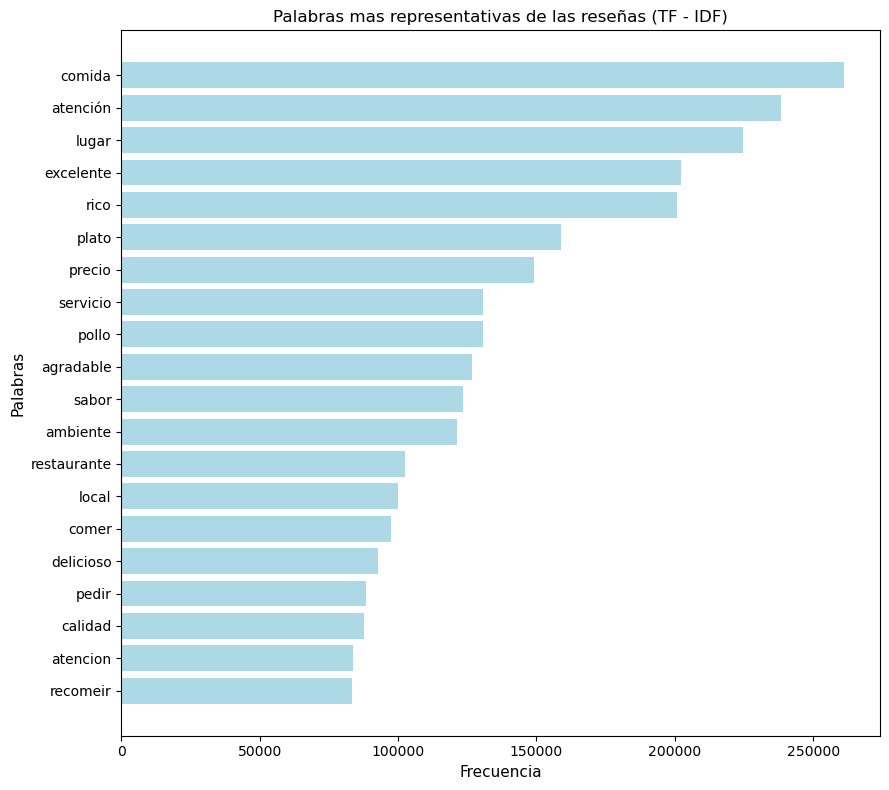

In [4]:
import matplotlib.pyplot as plt

data = {
    'comida': 261083.4192,
    'atención': 238203.2074,
    'lugar': 224666.2228,
    'excelente': 202072.7349,
    'rico': 200945.6529,
    'plato': 159020.9280,
    'precio': 148946.3873,
    'servicio': 130751.2297,
    'pollo': 130558.7563,
    'agradable': 126770.1833,
    'sabor': 123399.9673,
    'ambiente': 121407.0806,
    'restaurante': 102556.0827,
    'local': 100117.6376,
    'comer': 97440.4443,
    'delicioso': 92561.6321,
    'pedir': 88219.0456,
    'calidad': 87663.1681,
    'atencion': 83553.2682,
    'recomeir': 83201.0338
}

sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))

words = list(sorted_data.keys())
frequencies = list(sorted_data.values())

plt.figure(figsize=(9, 8))
plt.barh(words, frequencies, color='lightblue')

plt.title('Palabras mas representativas de las reseñas (TF - IDF)', fontsize=12)
plt.xlabel('Frecuencia', fontsize=11)
plt.ylabel('Palabras', fontsize=11)

# for i, v in enumerate(frequencies):
#    plt.text(v + 600, i, str(v), va='center')

plt.tight_layout()
plt.show()

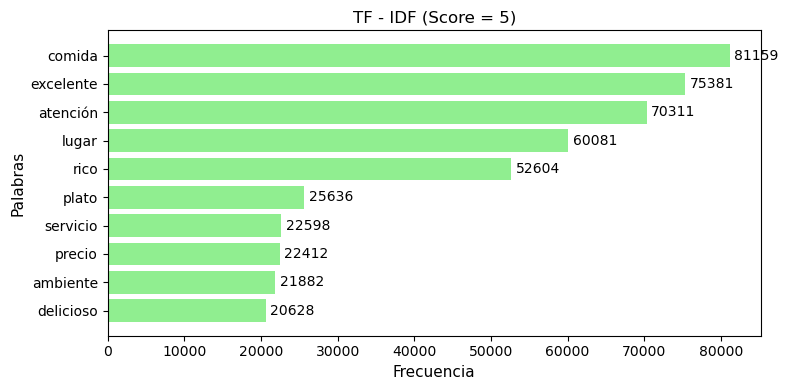

In [5]:
import matplotlib.pyplot as plt

data = {
    'comida': 81159,
    'excelente': 75381,
    'atención': 70311,
    'lugar': 60081,
    'rico': 52604,
    'plato': 25636,
    'servicio': 22598,
    'precio': 22412,
    'ambiente': 21882,
    'delicioso': 20628
}

sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))

words = list(sorted_data.keys())
frequencies = list(sorted_data.values())

plt.figure(figsize=(8, 4))
plt.barh(words, frequencies, color='lightgreen')

plt.title('TF - IDF (Score = 5)', fontsize=12)
plt.xlabel('Frecuencia', fontsize=11)
plt.ylabel('Palabras', fontsize=11)

for i, v in enumerate(frequencies):
    plt.text(v + 600, i, str(v), va='center')

plt.tight_layout()
plt.show()

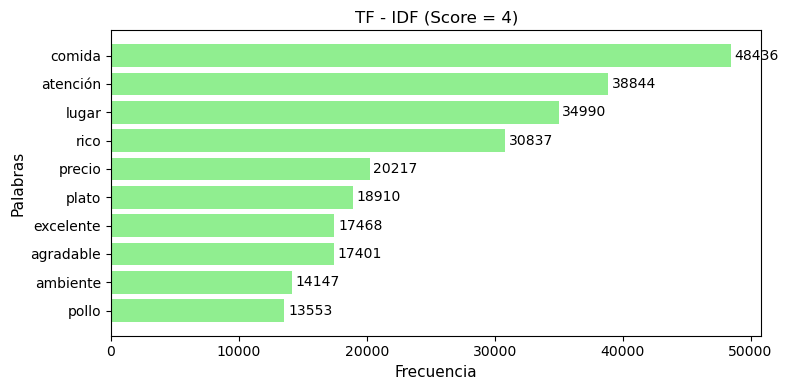

In [6]:
import matplotlib.pyplot as plt

data = {
    'comida': 48436,
    'atención': 38844,
    'lugar': 34990,
    'rico': 30837,
    'precio': 20217,
    'plato': 18910,
    'excelente': 17468,
    'agradable': 17401,
    'ambiente': 14147,
    'pollo': 13553
}

sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))

words = list(sorted_data.keys())
frequencies = list(sorted_data.values())

plt.figure(figsize=(8, 4))
plt.barh(words, frequencies, color='lightgreen')

plt.title('TF - IDF (Score = 4)', fontsize=12)
plt.xlabel('Frecuencia', fontsize=11)
plt.ylabel('Palabras', fontsize=11)

for i, v in enumerate(frequencies):
    plt.text(v + 300, i, str(v), va='center')

plt.tight_layout()
plt.show()

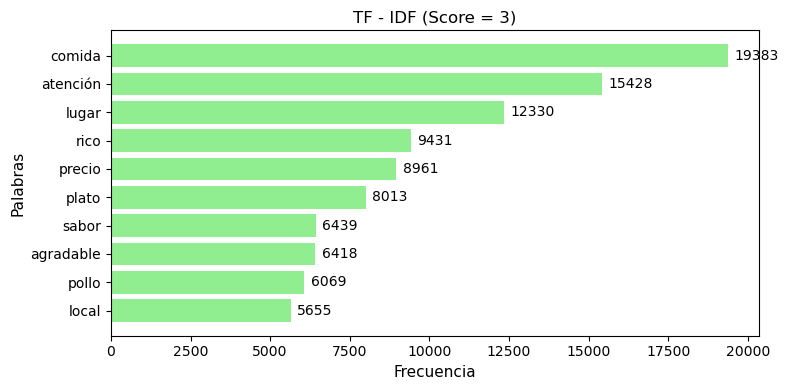

In [7]:
import matplotlib.pyplot as plt

data = {
    'comida': 19383,
    'atención': 15428,
    'lugar': 12330,
    'rico': 9431,
    'precio': 8961,
    'plato': 8013,
    'sabor': 6439,
    'agradable': 6418,
    'pollo': 6069,
    'local': 5655
}

sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))

words = list(sorted_data.keys())
frequencies = list(sorted_data.values())

plt.figure(figsize=(8, 4))
plt.barh(words, frequencies, color='lightgreen')

plt.title('TF - IDF (Score = 3)', fontsize=12)
plt.xlabel('Frecuencia', fontsize=11)
plt.ylabel('Palabras', fontsize=11)

for i, v in enumerate(frequencies):
    plt.text(v + 200, i, str(v), va='center')

plt.tight_layout()
plt.show()

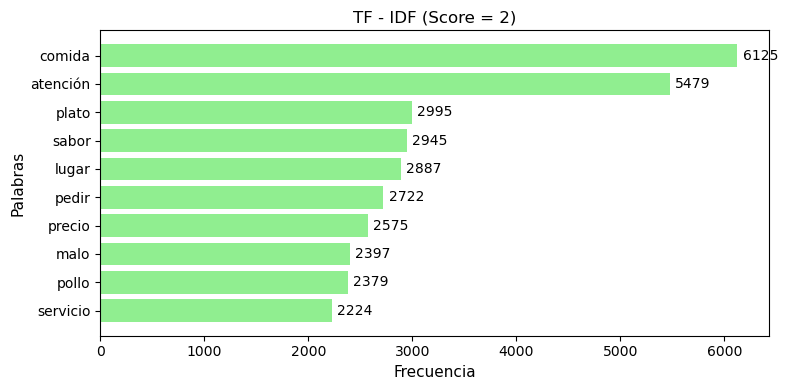

In [8]:
import matplotlib.pyplot as plt

data = {
    'comida': 6125,
    'atención': 5479,
    'plato': 2995,
    'sabor': 2945,
    'lugar': 2887,
    'pedir': 2722,
    'precio': 2575,
    'malo': 2397,
    'pollo': 2379,
    'servicio': 2224
}

sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))

words = list(sorted_data.keys())
frequencies = list(sorted_data.values())

plt.figure(figsize=(8, 4))
plt.barh(words, frequencies, color='lightgreen')

plt.title('TF - IDF (Score = 2)', fontsize=12)
plt.xlabel('Frecuencia', fontsize=11)
plt.ylabel('Palabras', fontsize=11)

for i, v in enumerate(frequencies):
    plt.text(v + 50, i, str(v), va='center')

plt.tight_layout()
plt.show()

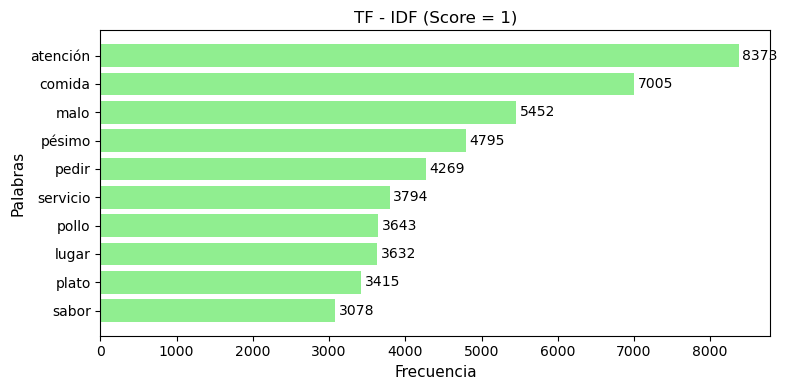

In [9]:
import matplotlib.pyplot as plt

data = {
    'atención': 8373,
    'comida': 7005,
    'malo': 5452,
    'pésimo': 4795,
    'pedir': 4269,
    'servicio': 3794,
    'pollo': 3643,
    'lugar': 3632,
    'plato': 3415,
    'sabor': 3078
}

sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))

words = list(sorted_data.keys())
frequencies = list(sorted_data.values())

plt.figure(figsize=(8, 4))
plt.barh(words, frequencies, color='lightgreen')

plt.title('TF - IDF (Score = 1)', fontsize=12)
plt.xlabel('Frecuencia', fontsize=11)
plt.ylabel('Palabras', fontsize=11)

for i, v in enumerate(frequencies):
    plt.text(v + 50, i, str(v), va='center')

plt.tight_layout()
plt.show()